## Exploring the MMDA data model

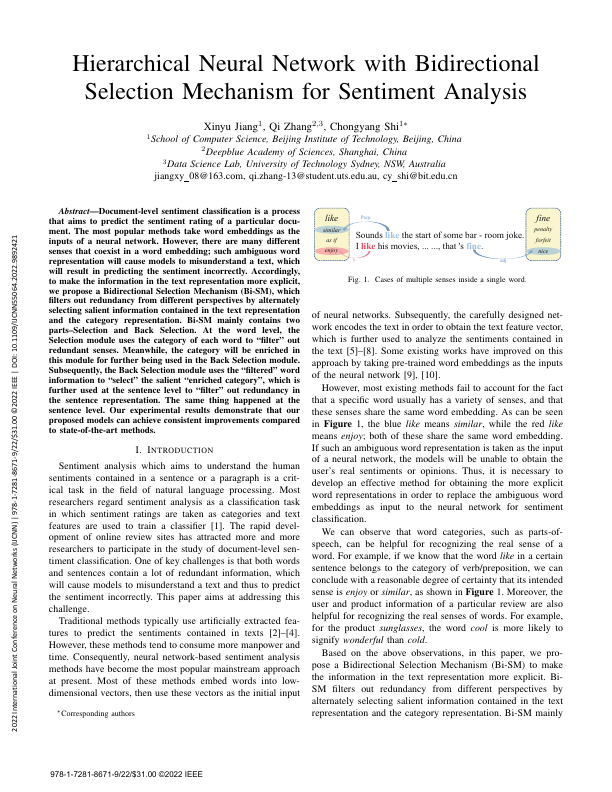

In [1]:
import json
from typing import *

from mmda.types import *
from mmda.parsers.pdfplumber_parser import PDFPlumberParser
from mmda.rasterizers.rasterizer import PDF2ImageRasterizer

sha = 'cca0ef8230a85e9dc233980ebb8d5778b8982394'
pdf_loc = '/Users/yogic/git/mmda/pdfs/cca0ef8230a85e9dc233980ebb8d5778b8982394.pdf'

images = list(PDF2ImageRasterizer().rasterize(pdf_loc, dpi=72))
images[0]

The __parser__ produces rows, tokens, and pages. All are of type List[SpanGroup].

Within each SpanGroup, every span has also a box.

In [2]:
doc = PDFPlumberParser().parse(pdf_loc)

def print_anno(anno):
    if type(anno) is SpanGroup:
        print(f"SpanGroup ", end='')
        print(json.dumps(anno.to_json(), indent=2))
    elif type(anno) is BoxGroup:
        print("BoxGroup ", end='')
        print(json.dumps(anno.to_json(), indent=2))

print(f"the first token = ", end='')
print_anno(doc.tokens[0])
print(f"the first row = ", end='')
print_anno(doc.rows[0])

the first token = SpanGroup {
  "spans": [
    {
      "start": 0,
      "end": 12,
      "box": [
        0.11806372549019607,
        0.06627090909090902,
        0.1930771568627451,
        0.030189393939394044,
        0
      ]
    }
  ],
  "metadata": {
    "id": 0,
    "type": null,
    "text": null
  },
  "uuid": "79d10e5d-4b35-4358-bd77-946503f0fcc9"
}
the first row = SpanGroup {
  "spans": [
    {
      "start": 0,
      "end": 46,
      "box": [
        0.11806372549019607,
        0.06627090909090902,
        0.7638698039215683,
        0.030189393939394044,
        0
      ]
    }
  ],
  "metadata": {
    "id": 0,
    "type": null,
    "text": null
  },
  "uuid": "49720c90-73f3-4e34-8f0d-8849d73b4b82"
}


Lets pretend to be some models called layoutparser and vila.

In [3]:
# from layoutparser, returns groups of boxes
boxes: List[BoxGroup] = [BoxGroup(id=1, boxes=[Box(0.1, 0.1, 0.2, 0.2, 1)])]
# from vila, returns groups of spans (individual spans have no box) 
elements: List[SpanGroup] = [SpanGroup(id=1, type='Title', spans=[Span(start=5, end=45, box=None)])]

print_anno(boxes[0])
print_anno(elements[0])

doc.annotate(boxes=boxes)
doc.annotate(elements=elements)

BoxGroup {
  "boxes": [
    [
      0.1,
      0.1,
      0.2,
      0.2,
      1
    ]
  ],
  "metadata": {
    "id": 1,
    "type": null
  },
  "uuid": "7623c42c-ab7b-433f-b961-4bda8fa590c9"
}
SpanGroup {
  "spans": [
    {
      "start": 5,
      "end": 45
    }
  ],
  "metadata": {
    "id": 1,
    "type": "Title",
    "text": null
  },
  "uuid": "e3d6d34c-16de-426a-b2f6-45617589cc8b"
}


MMDA converts `BoxGroup`s to `SpanGroup`s when annotated on a document. It leaves the orginial boxes you gave as input as a property called `box_group` on the each `SpanGroup`.

In [4]:
first_box_group = doc.boxes[0].to_json()
first_box_group['spans'] = first_box_group['spans'][:2]  # so that it prints less

print(type(doc.boxes[0]))
print(json.dumps(first_box_group, indent=2))

<class 'mmda.types.annotation.SpanGroup'>
{
  "spans": [
    {
      "start": 5744,
      "end": 5783,
      "box": [
        0.08000653594771241,
        0.09470960606060602,
        0.24964477941176466,
        0.012579545454545552,
        1
      ]
    },
    {
      "start": 5807,
      "end": 5845,
      "box": [
        0.08000653594771241,
        0.10980430303030318,
        0.26330320588235295,
        0.012579545454545413,
        1
      ]
    }
  ],
  "metadata": {
    "id": 0,
    "type": null,
    "text": null
  },
  "box_group": {
    "boxes": [
      [
        0.1,
        0.1,
        0.2,
        0.2,
        1
      ]
    ],
    "metadata": {
      "id": 1,
      "type": null
    },
    "uuid": "7623c42c-ab7b-433f-b961-4bda8fa590c9"
  },
  "uuid": "5f73a9f2-3033-4b43-88bd-8af81a947d49"
}


We can use MMDA to jump between annotation types.

In [5]:
print(f"number of tokens in the first page = {len(doc.pages[0].tokens)}")
print(f"number of rows in the second page = {len(doc.pages[1].rows)}")

number of tokens in the first page = 1084
number of rows in the second page = 108


In [6]:
for token in doc.rows[0].tokens:
    print(token.symbols)

['Hierarchical']
['Neural']
['Network']
['with']
['Bidirectional']


Every document has all of its text stored in a prop called `symbols` using which `SpanGroups` also derive a property of the same name.

The example below really shows the strength of MMDA in action. We annotated the document with a Box and now are able to retrieve the text enclosed by that box.

In [7]:
doc.boxes[0].symbols

['“ﬁlter” out redundant senses ( ﬁltering',
 'perspective ) and dynamically generate',
 'representations , and the category',
 'enriched in this module ; and the',
 'uses the “ﬁltered” word information',
 '“enriched category” , which we called',
 'further used at the sentence level',
 'the sentence representation ( ﬁltering',
 'and context two perspectives ) .\nThe main contributions of our',
 'follows :\n• We propose a Bidirectional',
 'SM ) to alternately select salient',
 'corresponding category information']

The "vila" prediction doesn't contain boxes. Yet, we can find the overlapping tokens and list their boxes instead for a visual perspective.

In [8]:
print_anno(doc.elements[0])
print()

for token in doc.elements[0].tokens:
    for box in token.spans:
        print(box.box.to_json())

SpanGroup {
  "spans": [
    {
      "start": 5,
      "end": 45
    }
  ],
  "metadata": {
    "id": 1,
    "type": "Title",
    "text": null
  },
  "uuid": "e3d6d34c-16de-426a-b2f6-45617589cc8b"
}

[0.11806372549019607, 0.06627090909090902, 0.1930771568627451, 0.030189393939394044, 0]
[0.32481490196078433, 0.06627090909090902, 0.1063057352941176, 0.030189393939394044, 0]
[0.4447946568627451, 0.06627090909090902, 0.13631044117647068, 0.030189393939394044, 0]
[0.5947791176470589, 0.06627090909090902, 0.06946401960784304, 0.030189393939394044, 0]
[0.677917156862745, 0.06627090909090902, 0.20401637254901936, 0.030189393939394044, 0]


In [9]:
print(type(doc))

<class 'mmda.types.document.Document'>


# Annotation Store

* __Document__ - Some immutable file. Can be text, pdf, or token-stream. The document type determines the annotations it can have.
* __Annotation__ - "sources" provide boxes as annotations for pdf documents, and spans for text documents.
* __Attributes__ - "sources" provide attributes attached to documents and/or annotations.

PDFAnnotation = (page, x, y, width, height, attributes)

TextAnnotation = (start, end, attributes)

## Document

In [11]:
import requests

url = "https://annotations-api.prod.s2.allenai.org"

s3_url = f"s3://ai2-s2-pdfs/{sha[:4]}/{sha[4:]}.pdf"
anno_doc = requests.post(f"{url}/pdf", json={"s3Url": s3_url}).json()
print(json.dumps(anno_doc, indent=2))

{
  "id": "cca0ef8230a85e9dc233980ebb8d5778b8982394",
  "s3Url": "s3://ai2-s2-pdfs/cca0/ef8230a85e9dc233980ebb8d5778b8982394.pdf"
}


## Attributes

In [13]:
anno_doc_id = anno_doc['id']
# source = 'yogi-data-team-meeting-demo'

resp = requests.get(f"{url}/pdf/{anno_doc_id}/annotations", params={"annotationSources": "none", "attributeSources": "all"}).json()
print(json.dumps(resp, indent=2))

{
  "docId": "cca0ef8230a85e9dc233980ebb8d5778b8982394",
  "attributesFromSource": {
    "pdfplumber-0.0.5": {
      "text": "s3://ai2-s2-science-parse-plus-prod/document/cca0ef8230a85e9dc233980ebb8d5778b8982394/pdfplumber-0.0.5/text",
      "images": [
        "s3://ai2-s2-science-parse-plus-prod/document/cca0ef8230a85e9dc233980ebb8d5778b8982394/pdfplumber-0.0.5/images/0",
        "s3://ai2-s2-science-parse-plus-prod/document/cca0ef8230a85e9dc233980ebb8d5778b8982394/pdfplumber-0.0.5/images/1",
        "s3://ai2-s2-science-parse-plus-prod/document/cca0ef8230a85e9dc233980ebb8d5778b8982394/pdfplumber-0.0.5/images/2",
        "s3://ai2-s2-science-parse-plus-prod/document/cca0ef8230a85e9dc233980ebb8d5778b8982394/pdfplumber-0.0.5/images/3",
        "s3://ai2-s2-science-parse-plus-prod/document/cca0ef8230a85e9dc233980ebb8d5778b8982394/pdfplumber-0.0.5/images/4",
        "s3://ai2-s2-science-parse-plus-prod/document/cca0ef8230a85e9dc233980ebb8d5778b8982394/pdfplumber-0.0.5/images/5",
        

Re-creating the MMDA doc from Annotation Store

In [17]:
# first we need to get the doc-id associated with the text file
s3_text_url = 's3://ai2-s2-science-parse-plus-prod/document/cca0ef8230a85e9dc233980ebb8d5778b8982394/pdfplumber-0.0.5/text'
anno_text_doc_id = requests.post(f"{url}/plain-text", json={"s3Url": s3_text_url}).json()["id"]
print(anno_text_doc_id)

722e68ede2457164fb91e7cadf90f7b1c647046d


In [20]:
anno_pdf_annotations = requests.get(
    f"{url}/pdf/{anno_doc_id}/annotations", params={"annotationSources": "pdfplumber-0.0.5", "attributeSources": "none"}
).json()['annotationsFromSource']['pdfplumber-0.0.5']
anno_text_annotations = requests.get(
    f"{url}/plain-text/{anno_doc_id}/annotations", params={"annotationSources": "pdfplumber-0.0.5", "attributeSources": "none"}
).json()['annotationsFromSource']['pdfplumber-0.0.5']

print(anno_pdf_annotations['pages'][0])
print(anno_text_annotations['pages'][0])